### In this notebook, we generate mock observations according to a given distribution of physical parameters. Then we try to recover the underlying distribution. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

Sigmoid and InvSigmoid work for parameters which should be constained to a finite range. The range doesn't need to be [0, 1]. For example, if the range of $x$ is [-3, 1], then the range of $(x+3)/4$ is [0, 1].

For our case, all parameters can be transformed using this method. 

CDF
$$
y = \frac{1}{2}\left[1+\operatorname{erf}\left(\frac{x-\mu}{\sigma \sqrt{2}}\right)\right]
$$

Inverse CDF

$$
x = \mu + \sigma \sqrt{2}\ \mathrm{erfinv}(2 y - 1)
$$

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar,

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : CDF_transform(logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift)**

We DON'T need any penalty!!!!

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
# filters = ['hsc_{0}'.format(b) for b in 'grizy']
# filters = ['galex_NUV'] + ['sdss_{0}0'.format(b) for b in 'ugriz'] + ['jwst_f090w', 'jwst_f115w', 'jwst_f140m']

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

#### Generate mock params

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

In [85]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # Log stellar mass, in M_sun
            prior.GaussianPrior(10.5, 0.4, label='logm'),
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
    #         prior.FlatDirichletPrior(ncomp, label='beta'),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 0.6, 0.2, 0.1, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 5, 1.5, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-2.6, 0.3, -1, 0.3, label='logzsol'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., -1, 0.3, label='dust_index'),
            # uniformly sample redshift
            prior.TruncatedNormalPrior(0., 0.3, 0.08, 0.04, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    _thetas = np.hstack([_thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 1:4]), 
               _thetas_unt[:, 4:]])
    
    return _thetas, _thetas_unt

In [86]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [87]:
_thetas, _thetas_unt = gen_truth(N_samples=30000)

In [71]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [88]:
_prior_NDE = speculator.bounds.copy()
# _prior_NDE[:4] = np.array([[0.1, 0.9], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]) # include fburst
# _prior_NDE[4] = np.array([1, 10])

# _prior_NDE[5] = np.array([-2.3, 0.2]) # logzsol
# _prior_NDE[6] = np.array([0.1, 2.9])
# _prior_NDE[7] = np.array([0.1, 2.9])
_prior_NDE[-2] = np.array([0., 0.1])
_prior_NDE[-1] = np.array([7.5, 12.5])

In [89]:
Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                     _thetas_unt[:, 0:1], # stellar mass
                    ])
Y_truth = torch.Tensor(Y_truth).to('cuda')
Y_truth_tr = transform_nmf_params(Y_truth, _prior_NDE).to('cpu')

X_data = speculator._predict_mag_with_mass_redshift_batch(Y_truth, 
                                                          filterset=filters,
                                                          noise=noise,
                                                          noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flag = flag & (~torch.isnan(Y_truth_tr).any(axis=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
         for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)
print('Number of bad photometry:', np.sum(~flag))
X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]
Y_truth_tr = Y_truth_tr[flag]

Number of bad photometry: 9377


In [90]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    ind = np.random.randint(0, len(X_data), 5000)
    X_datas.append(X_data[ind].to('cuda'))
    
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.05, 'scaling': 0.6})
print("Intrinsic sampling loss:", L(X_datas[0], X_datas[1]).item())
# Intrinsic sampling loss: 0.01805417239665985

Intrinsic sampling loss: 0.08206704258918762


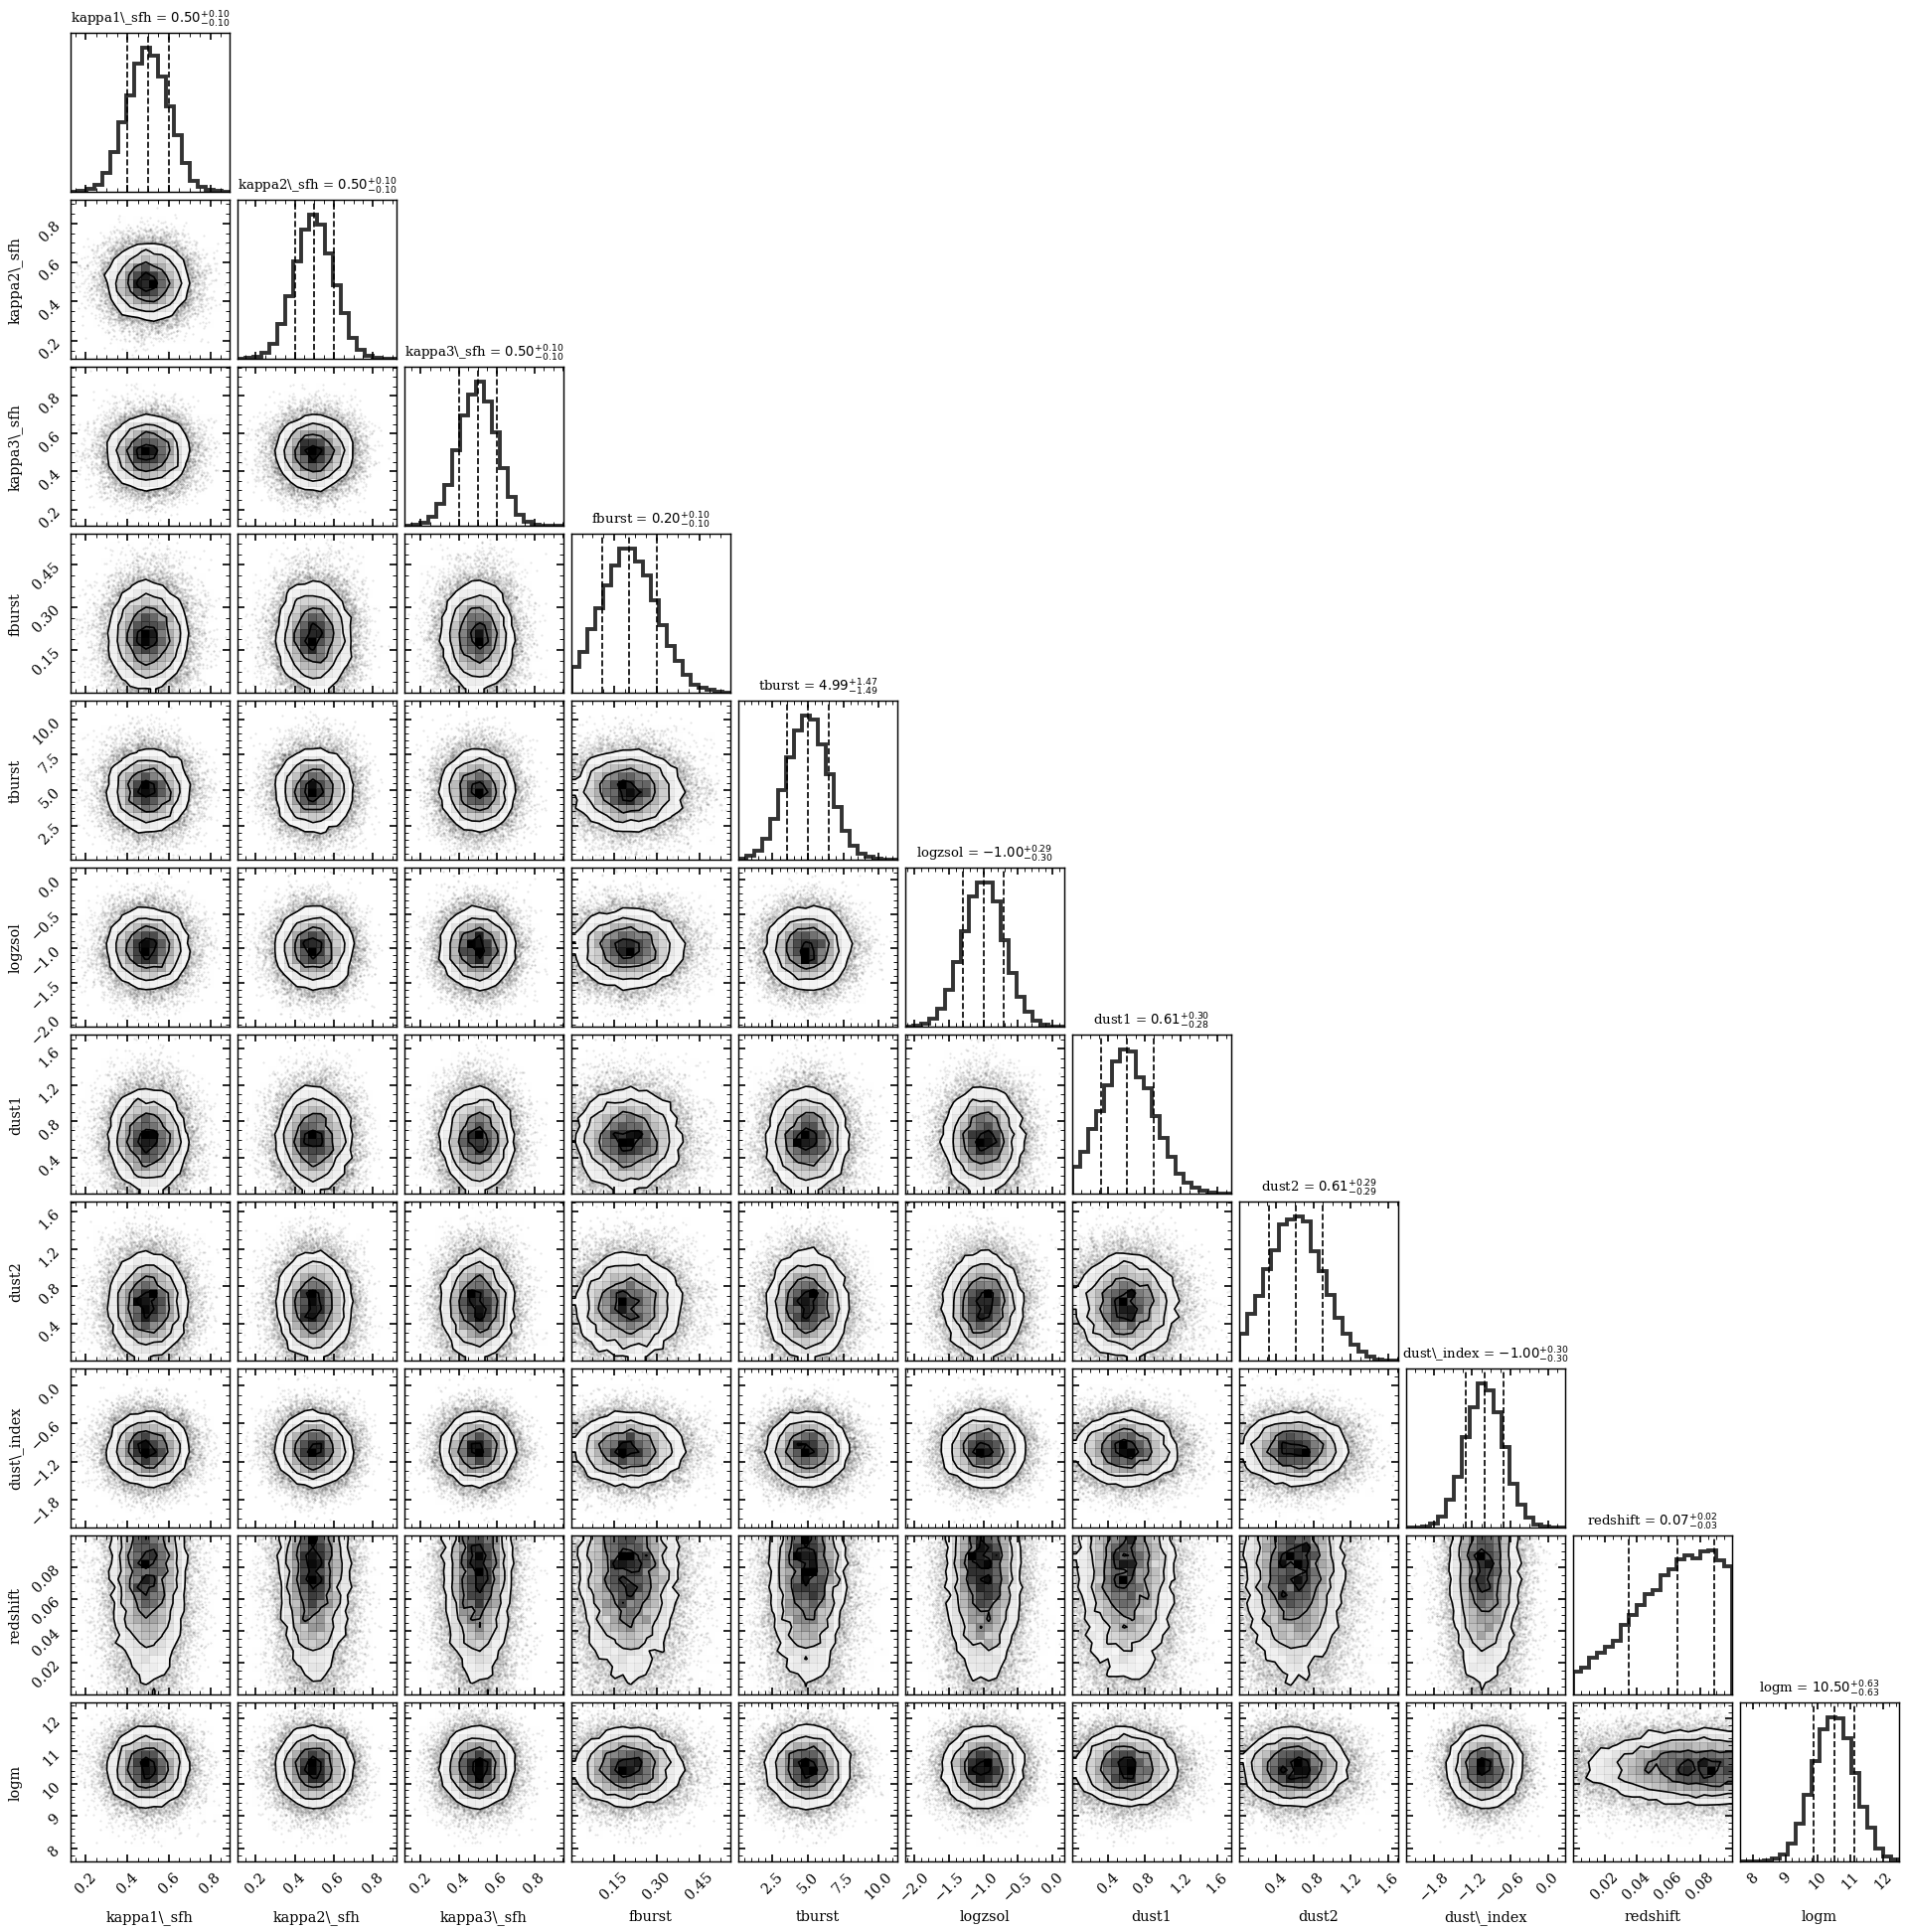

In [91]:
figure = corner.corner(Y_truth.cpu().detach().numpy(), 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=[key.replace('_', '\_') for key in speculator.params_name],
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

In [76]:
# X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth, test_size=0.1)
X_train, X_vali, Y_train, Y_vali = train_test_split(X_data, Y_truth_tr, test_size=0.1)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [77]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

seed = 0
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)

_stds = np.ones(len(_bounds))# / 250
# _bounds = (transform_nmf_params(torch.Tensor(_bounds).T).T).cpu().numpy()

# old hyperparams: 25, 40, 200
NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=5, #5,  # 10
                                              num_bins=40,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE
                                             )
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

NDE_theta.external_redshift_data = None
print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total number of params in the model: 542392


In [78]:
max_epochs = 3 # 6
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=2e-3, # 1e-3
                                                steps_per_epoch=100,
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100,
                    speculator=speculator,
                    only_penalty=False,
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': 1e-3, 'scaling': 0.6},
                    scheduler=scheduler, detect_anomaly=False,
                    )

    Epoch 0
    lr: 7.999999999999999e-05


Loss = 0.072 (train), 0.070 (vali), 0.000 (bad ratio): 100%|███████████| 100/100 [02:09<00:00,  1.29s/epochs]


    Epoch 1
    lr: 0.0019864906479611457


Loss = 0.061 (train), 0.063 (vali), 0.000 (bad ratio): 100%|███████████| 100/100 [02:08<00:00,  1.28s/epochs]


    Epoch 2
    lr: 0.0009103650496538022


Loss = 0.062 (train), 0.062 (vali), 0.000 (bad ratio): 100%|███████████| 100/100 [02:06<00:00,  1.27s/epochs]


In [14]:
# with open('./NDE/NMF/nde_theta_NMF_CDF_sdss_noise_largenet/nde_theta_best_loss_nsf_1.pkl', 'rb') as f:
#     _NDE_theta = pickle.load(f)
    
# with open('./NDE/NMF/nde_theta_NMF_CDF_sdss_noise_large/nde_theta_last_model_nsf_5.pkl', 'rb') as f:
#     _NDE_theta = pickle.load(f)

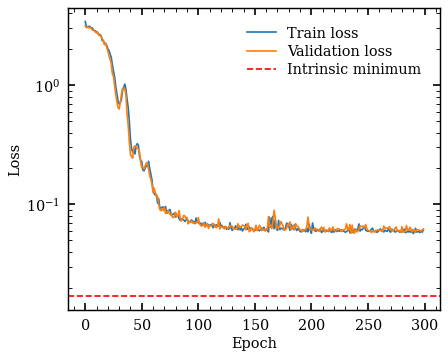

In [79]:
NDE_theta.plot_loss()
plt.yscale('log')

In [80]:
NDE_theta.vali_loss_history[-1]

0.0619545616209507

In [81]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 239
Best train loss: 0.06177491694688797
Best vali loss: 0.05704577639698982


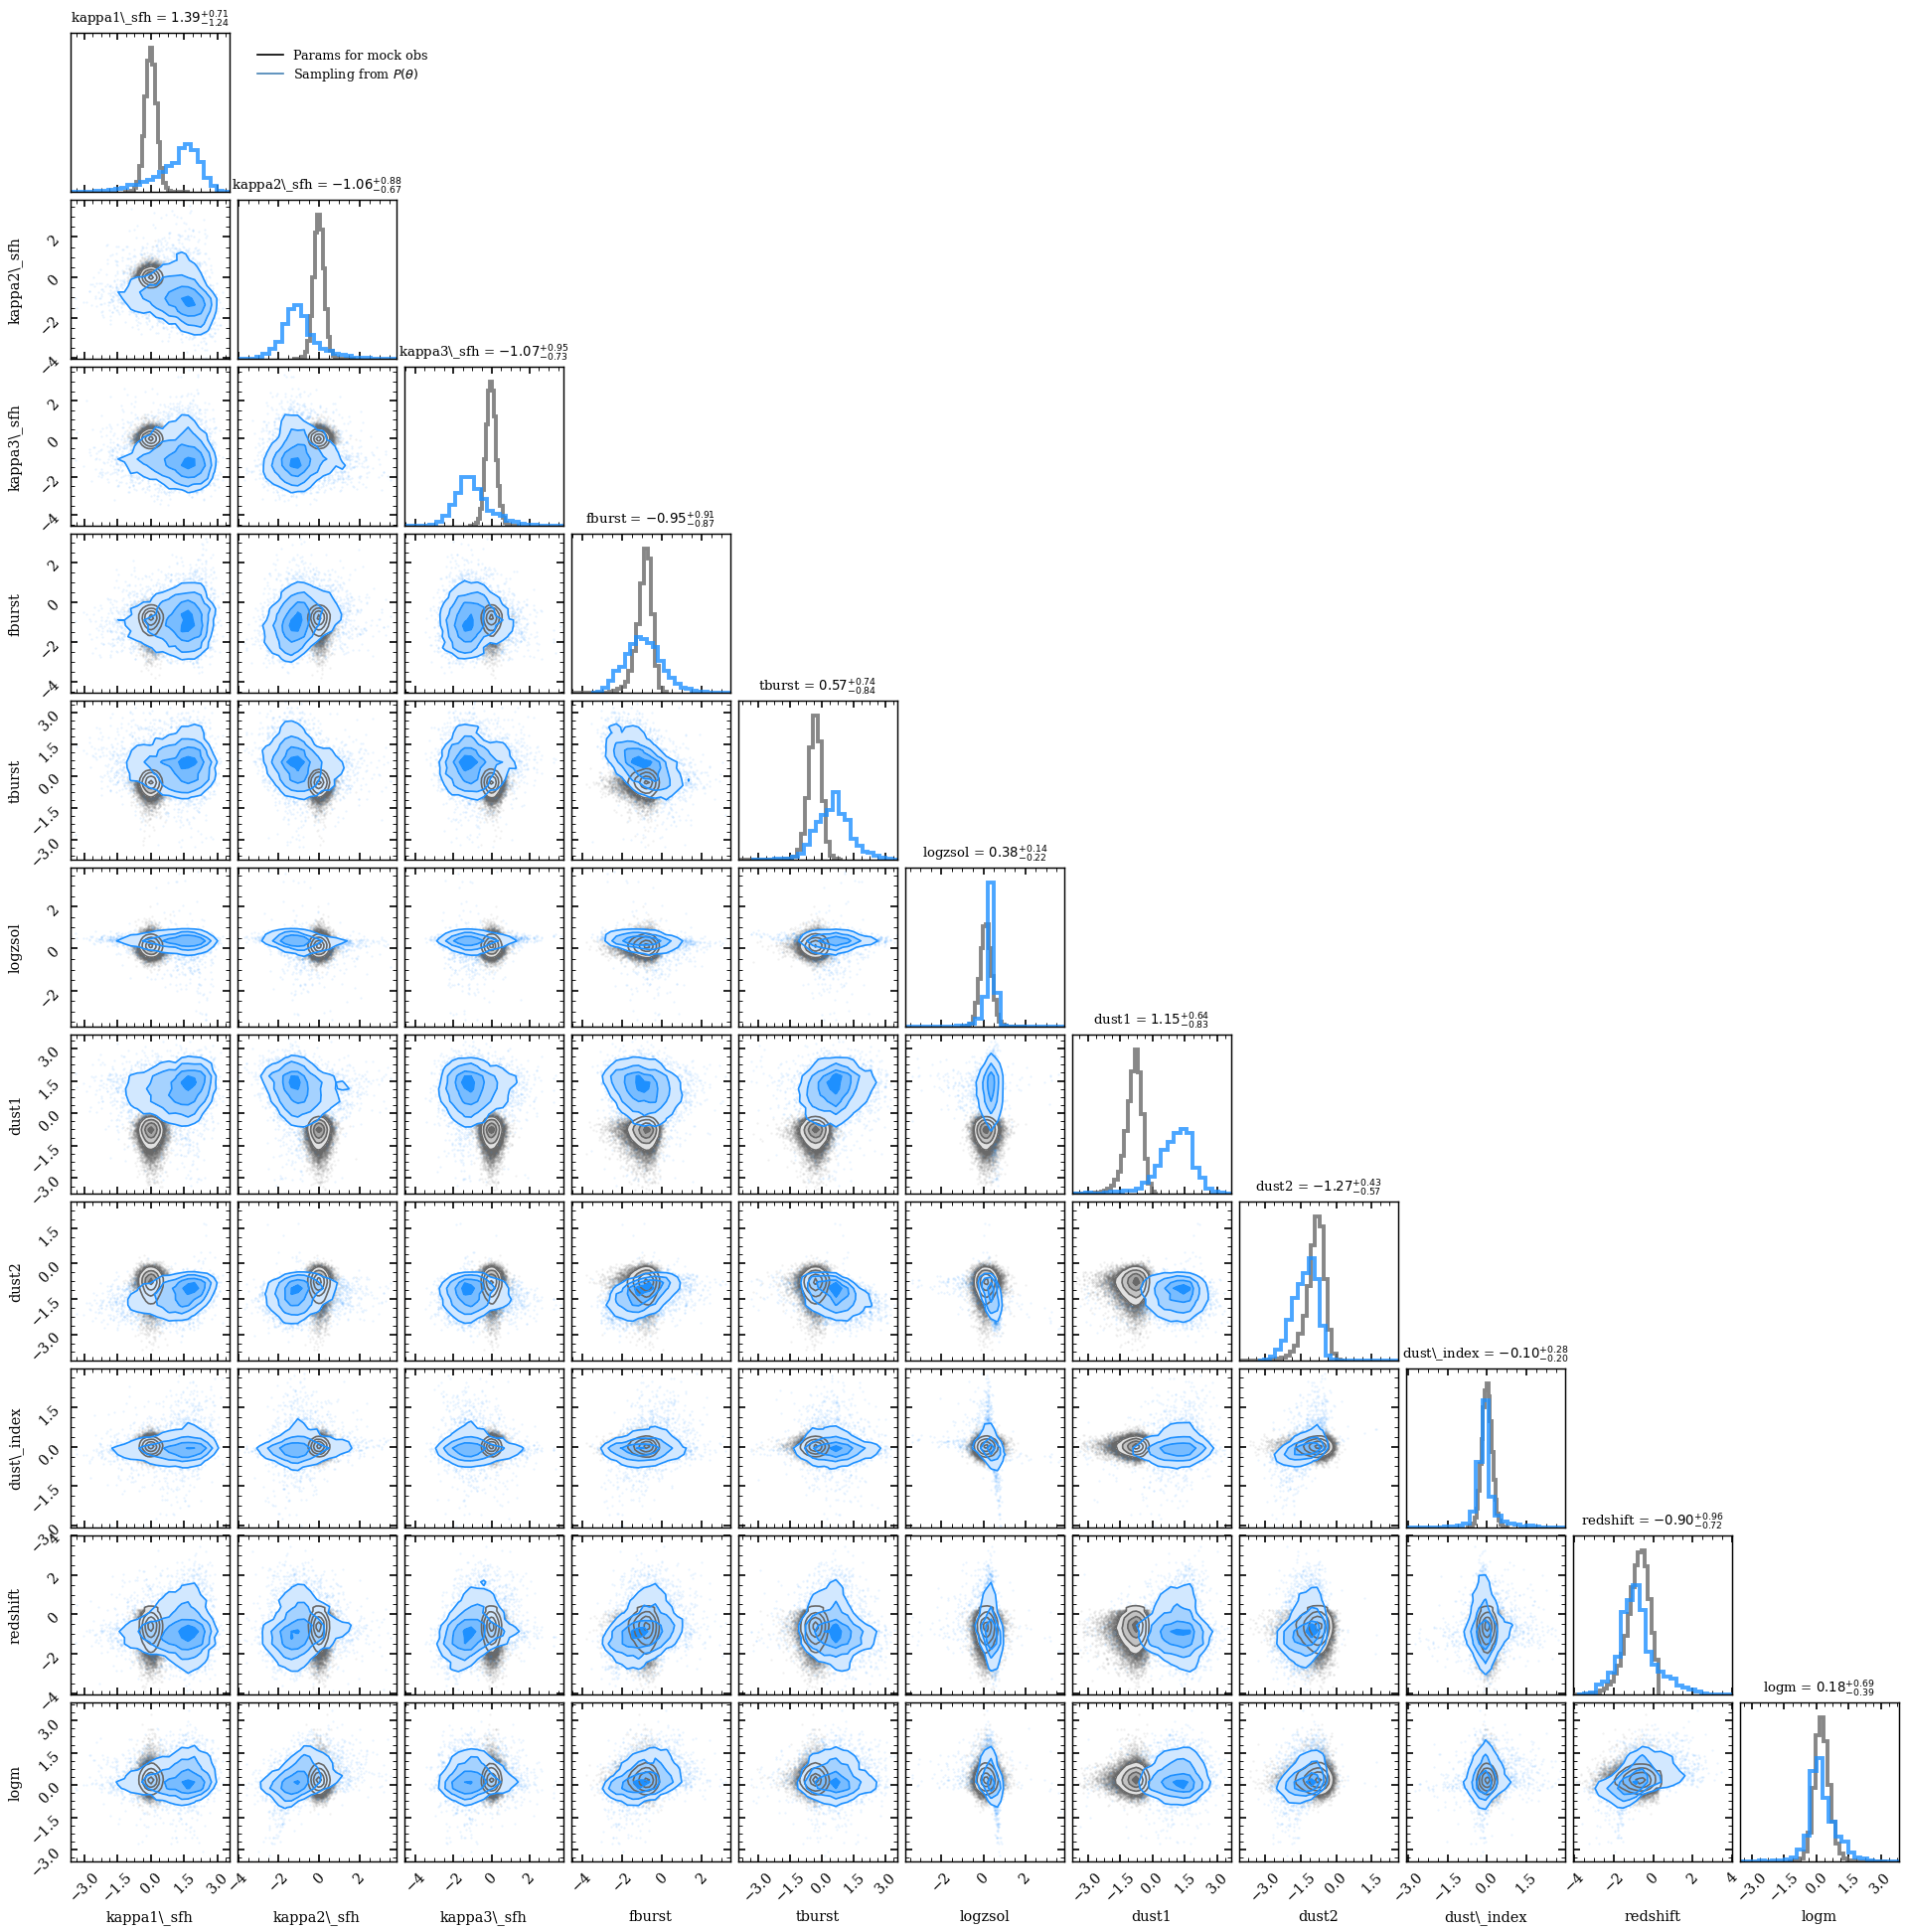

In [82]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(Y_truth_tr.cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       smooth=0.5, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

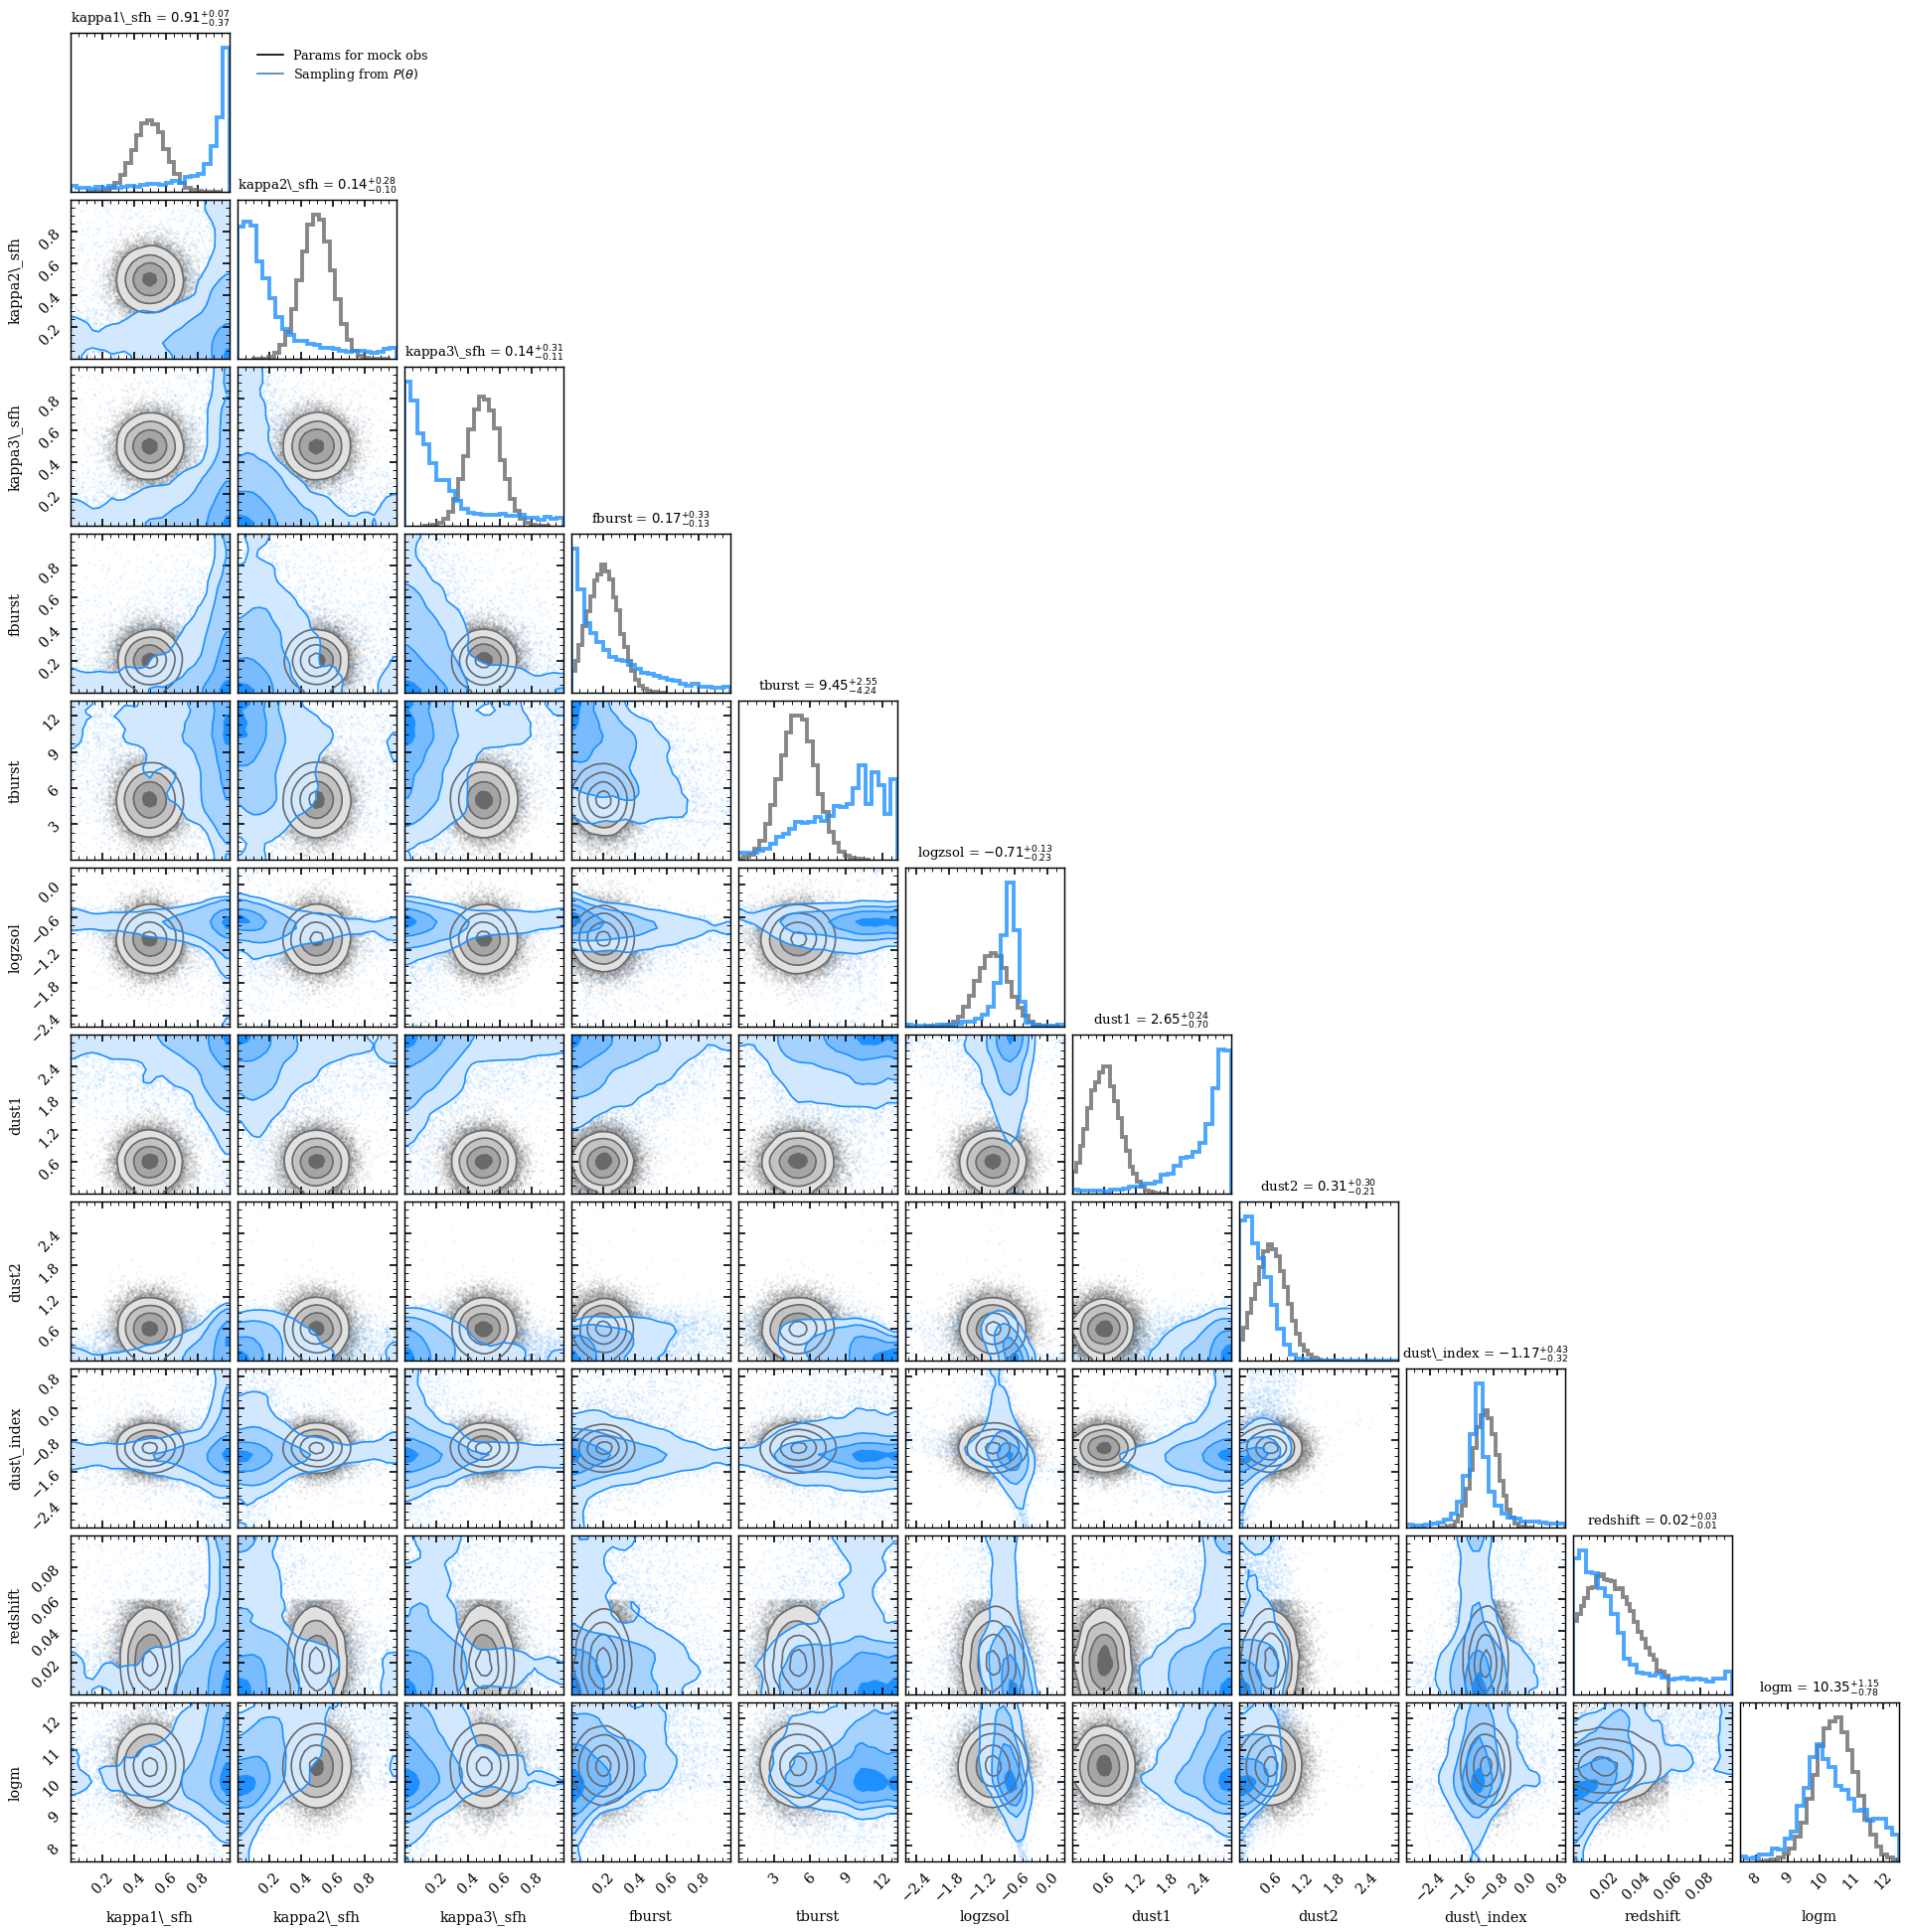

In [83]:
samples = NDE_theta.sample(10000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(inverse_transform_nmf_params(Y_truth_tr, _prior_NDE).cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(inverse_transform_nmf_params(samples, _prior_NDE).cpu().detach().numpy(), 
                      fig=figure, labels=labels, bins=25,
                      color='dodgerblue',
                      smooth=1, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

0 10000
>40 0


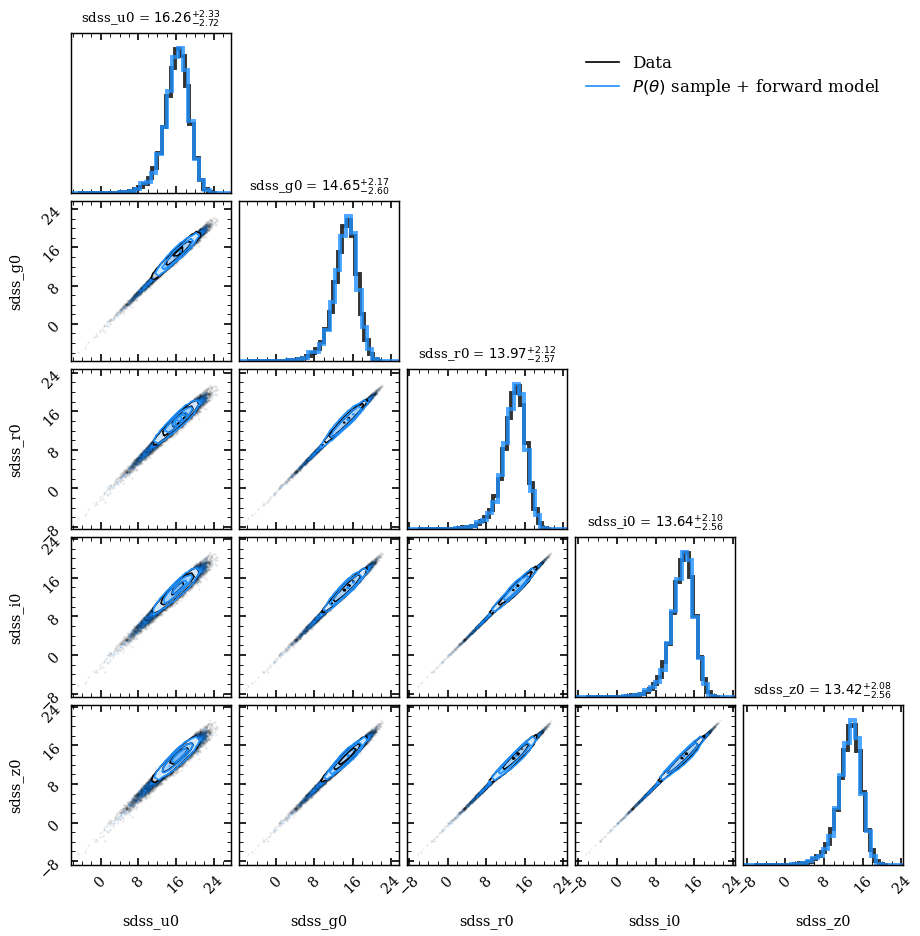

In [84]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(inverse_transform_nmf_params(samples, NDE_theta.NDE_prior),
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [101]:
_samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

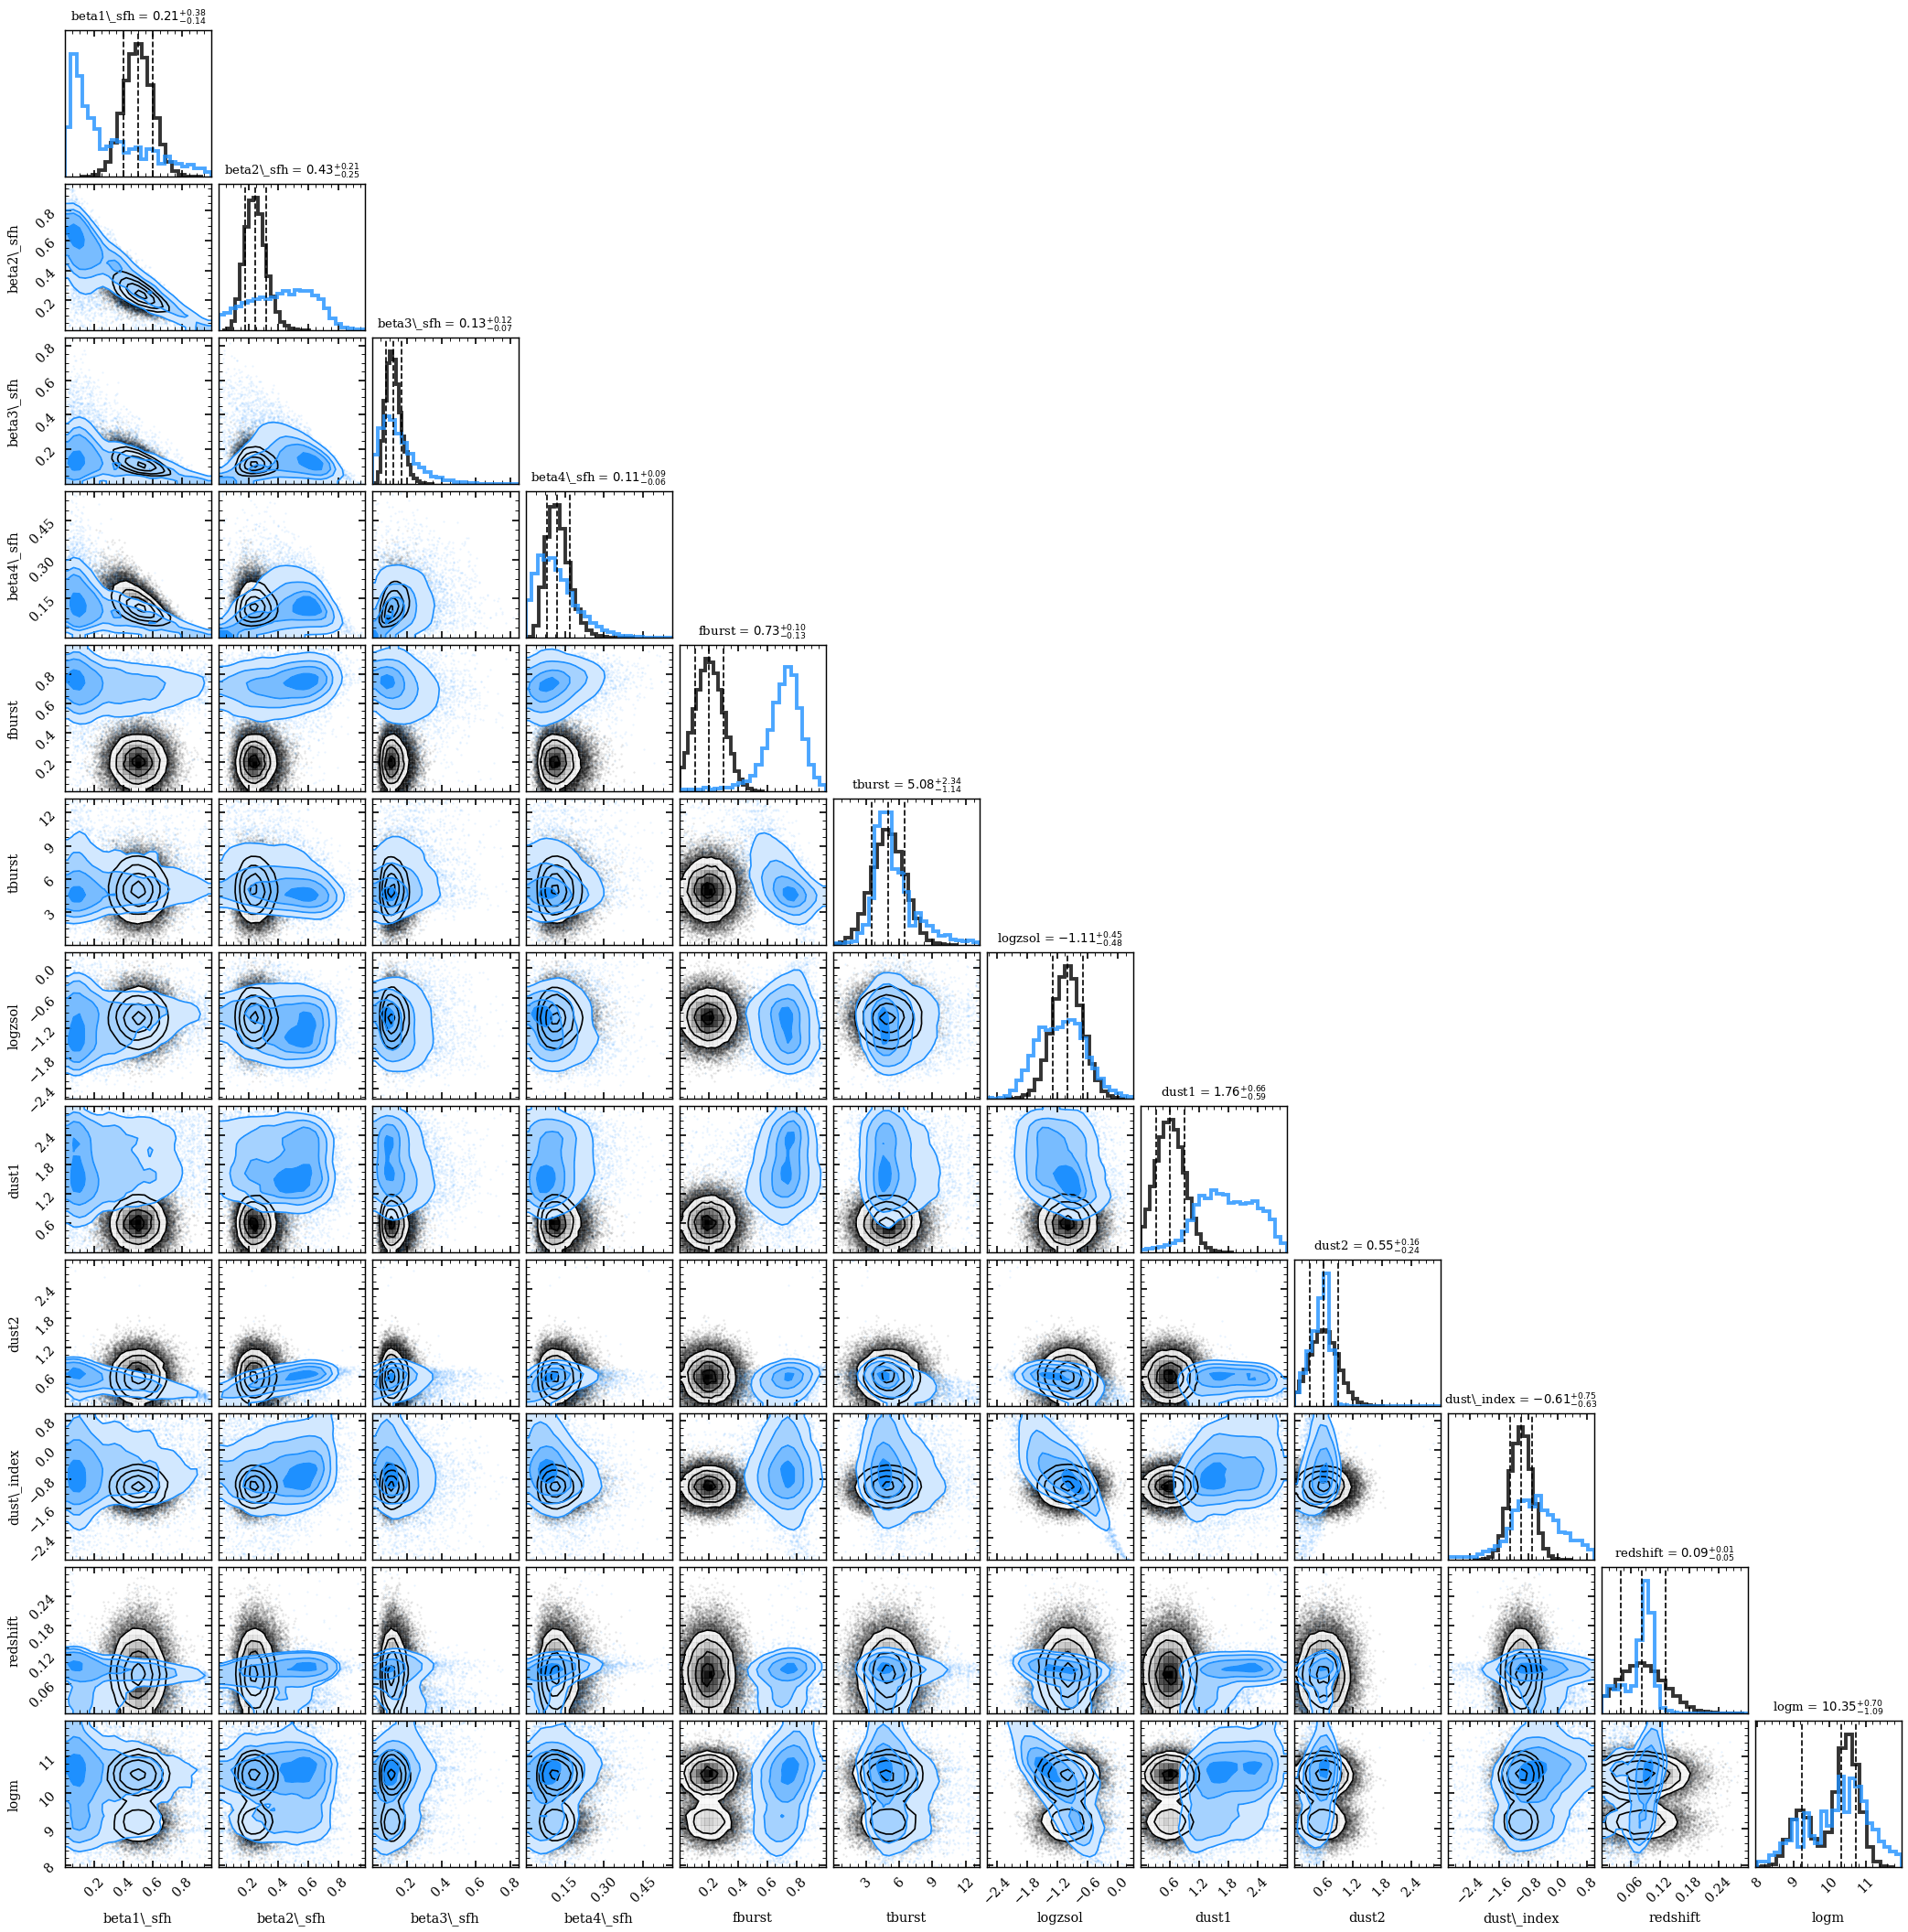

In [102]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [170]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

seed = 30
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)

_stds = np.ones(len(_bounds))# / 250
# _bounds = (transform_nmf_params(torch.Tensor(_bounds).T).T).cpu().numpy()

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=10,  # 10
                                              num_bins=15,  # how smashed it is. 10
                                              hidden_features=50,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE
                                             )
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total number of params in the model: 229990


In [171]:
from torch.utils.data import DataLoader
torch.autograd.set_detect_anomaly(True)

In [172]:
NDE_theta.optimizer.param_groups[0]['lr'] = 1e-5
loss_fn = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})

In [181]:
NDE_theta.optimizer.zero_grad()
n_samples = 1000
sample = inverse_transform_nmf_params(NDE_theta.sample(n_samples), NDE_theta.NDE_prior)

In [182]:
Y = NDE_theta.scaler.transform(
            speculator._predict_mag_with_mass_redshift(
                sample, filterset=NDE_theta.filterset,
                noise=noise, SNR=None, noise_model_dir=noise_model_dir),
            device=NDE_theta.device
        )

In [183]:
Y

tensor([[ 9.6467,  7.7089,  6.6021,  6.1089,  5.8177],
        [ 8.5267,  7.6212,  6.8832,  6.4769,  6.1660],
        [ 1.0786,  0.0747, -0.4391, -0.6985, -0.8267],
        ...,
        [ 2.0597,  1.0143,  0.3518,  0.0193, -0.2230],
        [ 4.6904,  4.1392,  3.5252,  3.1761,  3.0376],
        [ 3.4177,  3.9406,  4.0222,  4.1097,  4.2428]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [184]:
bad_mask = torch.stack([((sample < NDE_theta.bounds[i][0]) | (sample > NDE_theta.bounds[i][1]))[
            :, i] for i in range(len(NDE_theta.bounds))]).sum(dim=0, dtype=bool)
bad_mask |= (torch.isnan(Y).any(axis=1) | torch.isinf(Y).any(axis=1))

In [185]:
print('Bad mask num', bad_mask.sum())

Bad mask num tensor(0, device='cuda:0')


In [186]:
loss = loss_fn(Y, NDE_theta.X[:1000].to('cuda'))

In [187]:
loss

tensor(5.5273, device='cuda:0', grad_fn=<SelectBackward0>)

In [188]:
loss.backward()
NDE_theta.optimizer.step()

In [176]:
spec_rest = speculator._predict_spec_restframe(
        sample[:, :-1], log_stellar_mass=sample[:, -1:])  # restframe

In [180]:
torch.isnan(spec_rest).sum()

tensor(10004000, device='cuda:0')

In [174]:
speculator.speculators[0]._predict_spec_with_mass_restframe(torch.hstack([sample[:, :-1], torch.zeros_like(sample[:, 0:1])]))

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<PowBackward1>)

In [97]:
n_samples = 2000
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X, speculator, n_samples,
                                     noise, None, noise_model_dir, L,
                                     only_penalty=False, regularize=NDE_theta.regularize)

In [98]:
loss, bad_ratio

(tensor(19.0779, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(nan, device='cuda:0', grad_fn=<DivBackward0>))

In [91]:
loss.backward()
NDE_theta.optimizer.step()

In [92]:
sample = inverse_transform_nmf_params(NDE_theta.sample(2000), NDE_theta.NDE_prior)

In [ ]:
powers = torch.Tensor(self.penalty_powers).to(self.device)
        penalty = log_prior(sample,
                            torch.Tensor(self.bounds).to(self.device),
                            powers)
        # print('Number of inf:', torch.isinf(penalty).sum())
        penalty = penalty[~torch.isinf(penalty)].nanmean()

In [68]:
from popsed.nde import log_prior

In [71]:
log_prior(sample, torch.Tensor(NDE_theta.bounds), torch.Tensor(NDE_theta.penalty_powers)).mean()

tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward0>)

In [142]:
NDE_theta.penalty_powers = [10] * 11

In [144]:
n_samples = len(NDE_theta.X.detach())

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})


NDE_theta.optimizer.param_groups[0]['lr'] = 1e-6
NDE_theta.optimizer.zero_grad()
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L)
print(loss, bad_ratio)
loss.backward()
# NDE_theta.optimizer.step()
#     NDE_theta.sample(1)

Bad mask num tensor(3296, device='cuda:0')
Number of inf: tensor(0, device='cuda:0')
tensor(14.0700, device='cuda:0', grad_fn=<AddBackward0>) tensor(13.3888, device='cuda:0', grad_fn=<MeanBackward0>)


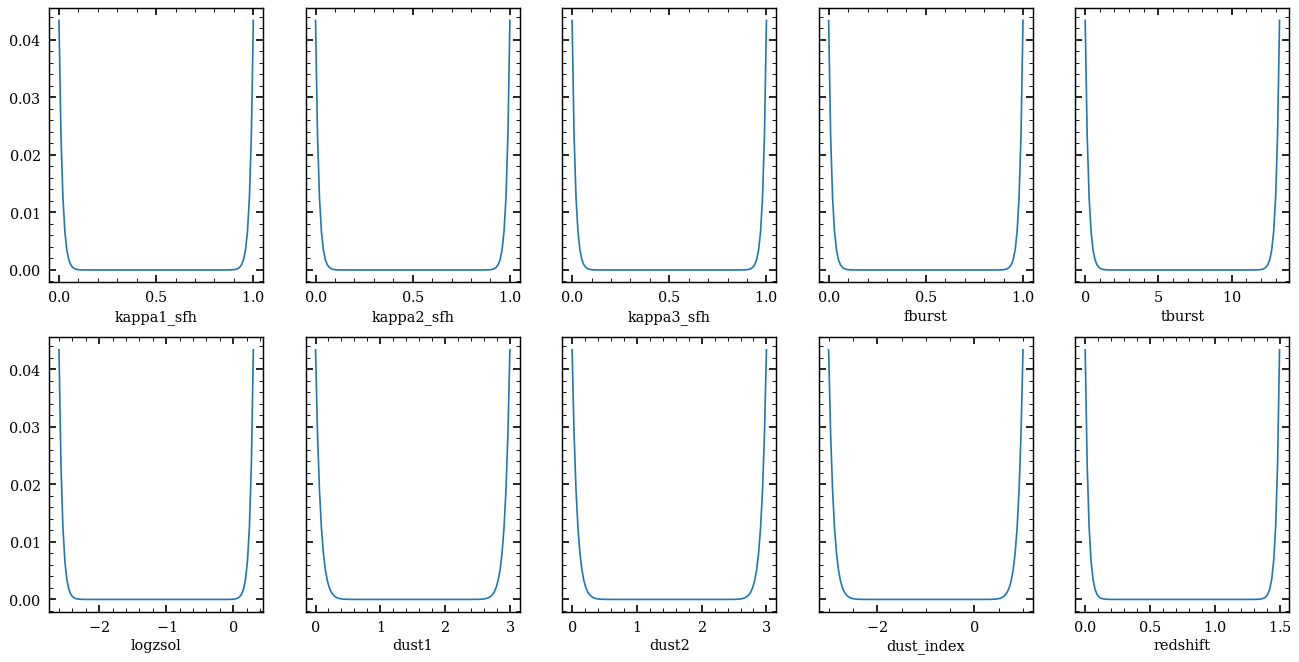

In [209]:
#### Plot the penalty

from popsed.nde import fuzzy_logic_prior

bounds = torch.Tensor(NDE_theta.bounds)

powers = NDE_theta.penalty_powers # [10] * 11
# [50] * 3 + [50] * 2 + [50] + [30] * 3 + [50] * 2
width = (bounds[:, 1] - bounds[:, 0]) / 2
loc = (bounds[:, 1] + bounds[:, 0]) / 2
index = torch.ones_like(loc) * 3

fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
for i in range(10):
    plt.sca(axes[i//5, i%5])
    par = torch.linspace(*bounds[i], 100)
    _penalty = fuzzy_logic_prior(par, loc[i], 10 ** (index[i] / powers[i]) * width[i], powers[i])
    plt.plot(par.cpu().numpy(), _penalty.cpu().numpy())
    plt.xlabel(NDE_theta.params_name[i])
    
plt.subplots_adjust(hspace=0.2)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [50]:
# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    _thetas, _thetas_unt = gen_truth(N_samples=5000)
    Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                         _thetas_unt[:, 0:1], # stellar mass
                        ])
    Y_truth = torch.Tensor(Y_truth).to('cuda')
    _X_data = NDE_theta.scaler.transform(speculator._predict_mag_with_mass_redshift(Y_truth, filterset=filters,
                        noise=noise, 
                        noise_model_dir=noise_model_dir).to('cpu'))
    flag = ~(torch.isnan(_X_data).any(dim=1) | torch.isinf(_X_data).any(dim=1))
#     flag = flag & (~torch.isnan(Y_truth_tr).any(axis=1))
    flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
             for i in range(len(speculator.bounds))]
    flag = flag.cpu().numpy() & np.array(flags).all(axis=0)
    
    _X_data = _X_data[flag]
    X_datas.append(_X_data.to('cuda'))
    
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.01, 'scaling': 0.9})
print("Intrinsic sampling loss:", L(X_datas[0], X_datas[1]).item())
# Intrinsic sampling loss: 0.01805417239665985

Intrinsic sampling loss: 0.047491852194070816
